AC OPT ANNUAL ELECTRICITY COST SAVINGS USING qualified_AC_ver4-2.csv DATASET (MULTI FAMILY, RETAIL, OFFICE)


In [225]:
import pandas as pd
import numpy as np

import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [226]:
# Import simulation data
simdata = pd.read_csv("Free (Basic).csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdata.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdata, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
#merged.head()

# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Renaming some columns
merged = merged.rename(columns={"year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water",
                                "annual electricity cost saving ($)": "elec_cost_saving"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"] = merged["annual_water"]/merged["floor_area"]

Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


In [227]:
EBEWE_buildings = pd.read_csv("qualified_AC_ver4-2.csv") 
unique = EBEWE_buildings.replace('Not Available',np.NaN)
unique = EBEWE_buildings.replace('',np.NaN)
unique = EBEWE_buildings.replace(' ',np.NaN)

# Renaming some columns
unique = unique.rename(columns={"baseline.annual.site.energy.use.intensity..kWh.m2.": "site_eui"})

unique.shape

(2155, 43)

In [228]:
# Selecting only multi-family housing
regdata1 = merged[(merged["building type"] == "Multi Family House")]
regdata1.shape

(118, 110)

In [229]:
regdata1 = regdata1[["elec_cost_saving","floor_area","site_eui"]]

# Scaling the data
#scaler = MinMaxScaler()
#scaler.fit(regdata1[["floor_area","site_eui","annual_water"]])
#regdata1[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata1[["floor_area","site_eui","annual_water"]])

regdata1.head()

,elec_cost_saving,floor_area,site_eui
3,1242.97,67203.449510,90.5098
5,1154.85,87762.735316,82.8352
7,786.88,34602.397177,96.1825
9,1425.86,85770.122148,91.8548
13,1053.10,51835.279445,92.7864


In [230]:
# Regression model
res1 = smf.ols('elec_cost_saving ~ floor_area + site_eui  + np.power(floor_area,2) -1', data=regdata1).fit()
print(res1.summary())

                                 OLS Regression Results                                
Dep. Variable:       elec_cost_saving   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              655.2
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    4.15e-72
Time:                        07:18:43   Log-Likelihood:                         -855.86
No. Observations:                 118   AIC:                                      1718.
Df Residuals:                     115   BIC:                                      1726.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

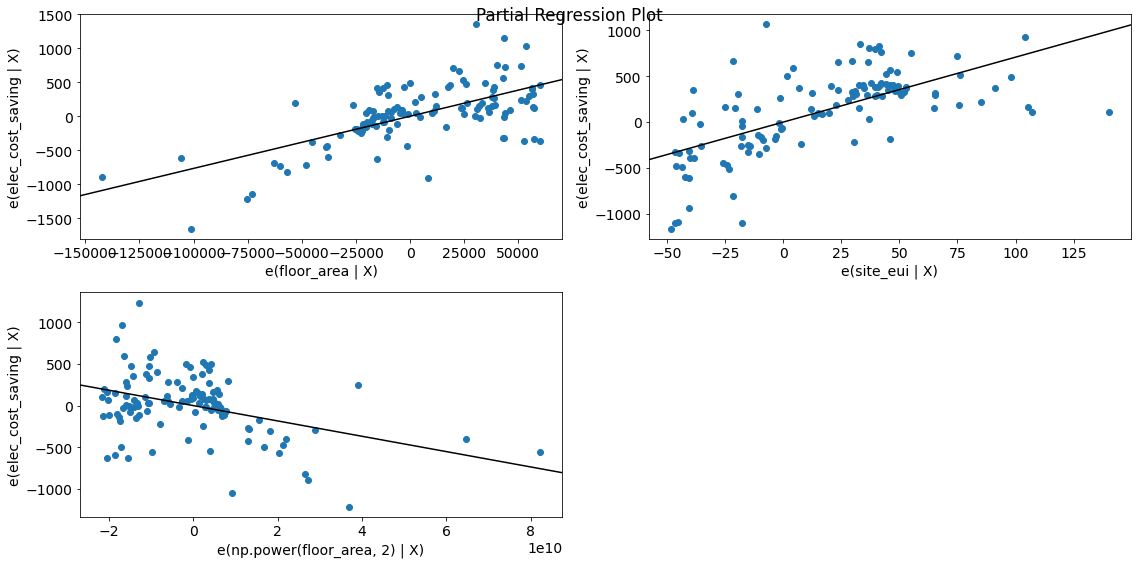

In [231]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res1)
fig.tight_layout(pad=1.0)

In [232]:
# Select only medium multi-family 
multi_medium = unique[(unique["PROPERTY.TYPE"]=="Multifamily Housing")]
multi_medium.shape

(2006, 43)

In [233]:
# Selecting regression x_variables
xvariables1 = multi_medium[["BUILDING.ID", "floor_area", "site_eui","floor_area_2"]]

# Scale data
#scaler = MinMaxScaler()
#scaler.fit(xvariables[["floor_area", "site_eui", "annual_water"]])
#xvariables[["floor_area", "site_eui", "annual_water"]] = scaler.transform(xvariables[["floor_area","site_eui","annual_water"]])

In [234]:
# Predicting # of HVAC Units
xvariables1['pred_elec_cost_saving_CDIMF'] = res1.predict(xvariables1[["floor_area","site_eui","floor_area_2"]])
pd.set_option('display.max_rows', 50)
xvariables1

,BUILDING.ID,floor_area,site_eui,floor_area_2,pred_elec_cost_saving_CDIMF
0,617,90684,31.4,8223587856,842.951851
1,3626,342600,42.3,117374760000,1848.657246
2,5817,64873,32.7,4208506129,690.865112
3,6228,340691,27.0,116070357481,1737.831503
4,6522,468945,33.0,219909413025,1807.725980
...,...,...,...,...,...
2149,999000000426,50336,37.8,2533712896,630.683665
2151,999000000494,231034,63.7,53376709156,1733.181465
2152,999000000495,238932,38.1,57088500624,1578.596000
2153,999000000496,70000,256.8,4900000000,2308.570406


In [235]:
import statistics
df = xvariables1['pred_elec_cost_saving_CDIMF']
np.nanmedian(df)

578.5941022326049

In [236]:
multifam_mean = (np.mean(df))
multifam_mean

645.9875751896473

In [237]:
df.sum()

1295851.075830434

In [238]:
pred_elec_cost_saving_CDIMF = xvariables1[['BUILDING.ID','pred_elec_cost_saving_CDIMF']]
pred_elec_cost_saving_CDIMF

,BUILDING.ID,pred_elec_cost_saving_CDIMF
0,617,842.951851
1,3626,1848.657246
2,5817,690.865112
3,6228,1737.831503
4,6522,1807.725980
...,...,...
2149,999000000426,630.683665
2151,999000000494,1733.181465
2152,999000000495,1578.596000
2153,999000000496,2308.570406


OFFICE


In [239]:
# Selecting only multi-family housing
regdata2 = merged[(merged["building type"] == "Small Office") | 
                  (merged["building type"] == "Medium Office") | 
                  (merged["building type"] == "Large Office")]
regdata2.shape

(117, 110)

In [240]:
regdata2 = regdata2[["elec_cost_saving","floor_area","site_eui"]]

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata2[["floor_area","site_eui"]])
regdata2[["floor_area","site_eui"]] = scaler.transform(regdata2[["floor_area","site_eui"]])

regdata2.head()

,elec_cost_saving,floor_area,site_eui
1,174002.74,0.129802,0.424684
11,79559.96,0.046135,0.555209
15,112716.30,0.078254,0.447290
17,51860.10,0.039085,0.069488
19,93407.22,0.065227,0.456016


In [241]:
# Regression model
res2 = smf.ols('elec_cost_saving ~ floor_area + site_eui + np.power(floor_area,2) -1', data=regdata2).fit()
print(res2.summary())

                                 OLS Regression Results                                
Dep. Variable:       elec_cost_saving   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              2895.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                   2.20e-107
Time:                        07:19:35   Log-Likelihood:                         -1422.6
No. Observations:                 117   AIC:                                      2851.
Df Residuals:                     114   BIC:                                      2859.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

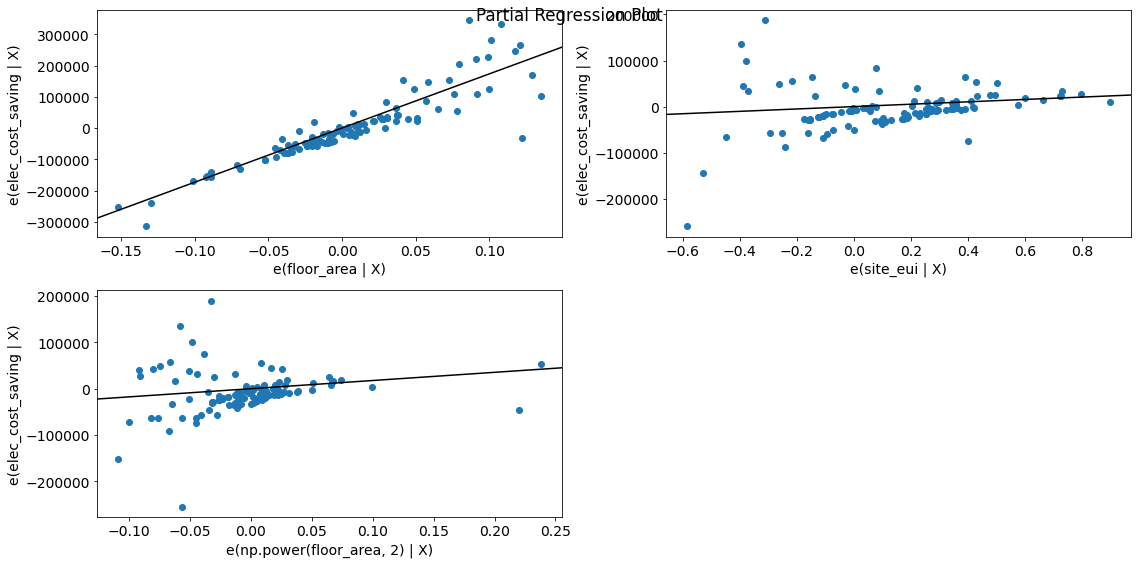

In [242]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res2)
fig.tight_layout(pad=1.0)

In [243]:
# Select only medium multi-family 
e_offices = unique[(unique["PROPERTY.TYPE"]=="Office")]
e_offices.shape

(72, 43)

In [244]:
# Selecting regression x_variables
xvariables2 = e_offices[["BUILDING.ID","floor_area","site_eui","floor_area_2"]]

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables2[["floor_area","site_eui","floor_area_2"]])
xvariables2[["floor_area","site_eui","floor_area_2"]] = scaler.transform(xvariables2[["floor_area","site_eui","floor_area_2"]])

In [245]:
# Predicting gas cost savings
xvariables2['pred_elec_cost_saving_CDIOFF'] = res2.predict(xvariables2[["floor_area","site_eui","floor_area_2"]])
pd.set_option('display.max_rows', 100)
xvariables2

,BUILDING.ID,floor_area,site_eui,floor_area_2,pred_elec_cost_saving_CDIOFF
73,379592888001,0.136235,0.450422,0.018886,2.512760e+05
79,380388902613,0.018999,0.163502,0.000413,3.724961e+04
86,381320910314,0.005018,0.488397,0.000039,2.132425e+04
87,381330910169,0.005738,0.490506,0.000049,2.262881e+04
88,381339909702,0.008929,0.409283,0.000104,2.607591e+04
95,381840910625,0.004670,0.522152,0.000035,2.159156e+04
101,382166909827,0.004714,0.257384,0.000035,1.483016e+04
103,382270908470,0.025916,0.018987,0.000742,4.557279e+04
104,382281907913,0.010037,0.118143,0.000128,2.048244e+04
110,382683907950,0.007006,0.089662,0.000068,1.447905e+04


In [246]:
df = xvariables2["pred_elec_cost_saving_CDIOFF"]
office_median = (np.nanmedian(df))
office_median

32188.029556807833

In [247]:
office_mean = (np.mean(df))
office_mean

237937.37849872434

In [248]:
df.sum()

17131491.25190816

In [249]:
pred_elec_cost_saving_CDIOFF = xvariables2[['BUILDING.ID','pred_elec_cost_saving_CDIOFF']]
pred_elec_cost_saving_CDIOFF

,BUILDING.ID,pred_elec_cost_saving_CDIOFF
73,379592888001,2.512760e+05
79,380388902613,3.724961e+04
86,381320910314,2.132425e+04
87,381330910169,2.262881e+04
88,381339909702,2.607591e+04
95,381840910625,2.159156e+04
101,382166909827,1.483016e+04
103,382270908470,4.557279e+04
104,382281907913,2.048244e+04
110,382683907950,1.447905e+04


RETAIL




In [250]:
# Selecting only multi-family housing
retail = merged[(merged["building type"] == "Small Retail") | 
                 (merged["building type"] == "Medium Retail") | 
                 (merged["building type"] == "Large Retail")]
retail.shape

(8, 110)

In [251]:
regdata3 = retail[["elec_cost_saving","floor_area","site_eui"]]

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata3[["floor_area","site_eui"]])
regdata3[["floor_area","site_eui"]] = scaler.transform(regdata3[["floor_area","site_eui"]])

regdata3.head()

,elec_cost_saving,floor_area,site_eui
105,55001.94,0.812663,0.068204
209,13190.69,0.002166,1.000000
243,34472.45,0.450261,0.000000
317,11462.94,0.000000,0.802666
351,24323.49,0.210197,0.330205


In [252]:
# Regression model
res3 = smf.ols('elec_cost_saving ~ floor_area + site_eui + np.power(floor_area,2) -1', data=regdata3).fit()
print(res3.summary())

                                 OLS Regression Results                                
Dep. Variable:       elec_cost_saving   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              150.4
Date:                Thu, 01 Apr 2021   Prob (F-statistic):                    2.55e-05
Time:                        07:20:25   Log-Likelihood:                         -79.074
No. Observations:                   8   AIC:                                      164.1
Df Residuals:                       5   BIC:                                      164.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

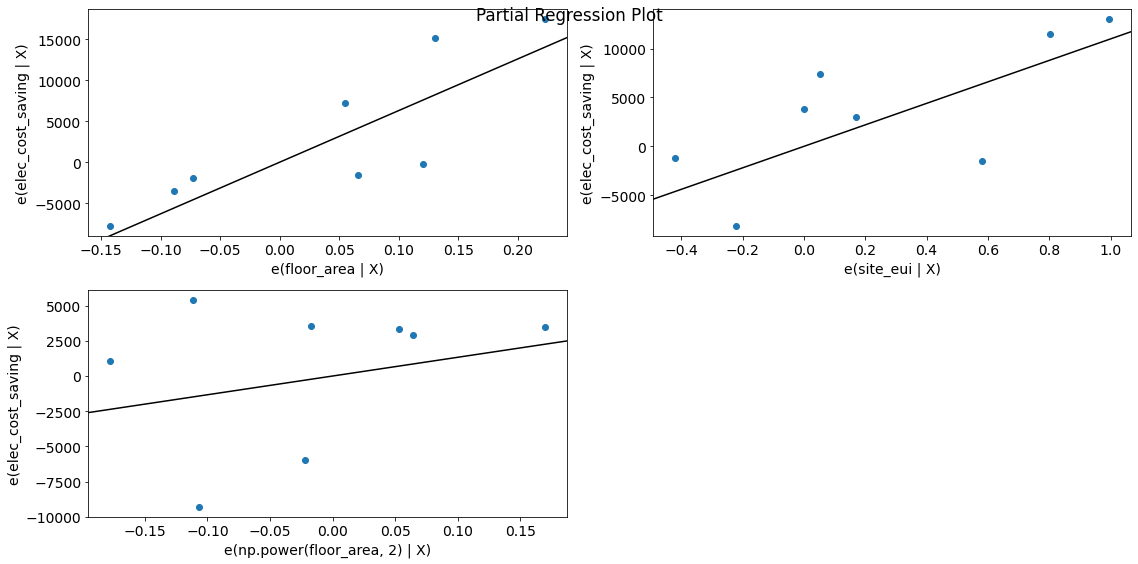

In [253]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res3)
fig.tight_layout(pad=1.0)

In [254]:
# Select only medium multi-family 
e_retail = unique[(unique["PROPERTY.TYPE"]=="Retail Store")]
e_retail.shape

(77, 43)

In [255]:
# Selecting regression x_variables
xvariables3 = e_retail[["BUILDING.ID", "floor_area", "site_eui","floor_area_2"]]

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables3[["floor_area","site_eui","floor_area_2"]])
xvariables3[["floor_area","site_eui","floor_area_2"]] = scaler.transform(xvariables3[["floor_area","site_eui","floor_area_2"]])

In [256]:
# Predicting gas cost saving
xvariables3['pred_elec_cost_saving_CDIRET'] = res3.predict(xvariables3[["site_eui","floor_area","floor_area_2"]])
pd.set_option('display.max_rows', 100)
xvariables3

,BUILDING.ID,floor_area,site_eui,floor_area_2,pred_elec_cost_saving_CDIRET
41,370244899060,0.182668,0.237453,0.048572,14556.902630
56,378702892165,0.489614,0.475655,0.265170,39246.947647
64,379072892713,1.000000,0.205993,1.000000,78526.360285
69,379328891539,0.866331,0.557303,0.762321,70655.464129
84,381005916882,0.237748,0.779026,0.074979,24286.453128
93,381639900770,0.264474,0.002996,0.089756,17617.281587
99,381980890380,0.515034,0.358801,0.290695,39902.547330
107,382479888785,0.048774,0.318352,0.007103,6602.559284
131,383377902547,0.208796,0.578277,0.060418,20084.663735
140,383508891239,0.134273,0.131835,0.029867,10144.400896


In [257]:
df = xvariables3["pred_elec_cost_saving_CDIRET"]
retail_median = (np.nanmedian(df))
retail_median

13816.441463280717

In [258]:
retail_mean = (np.mean(df))
retail_mean

20895.05616632502

In [259]:
df.sum()

1608919.324807027

In [260]:
pred_elec_cost_saving_CDIRET = xvariables3[['BUILDING.ID','pred_elec_cost_saving_CDIRET']]
pred_elec_cost_saving_CDIRET

,BUILDING.ID,pred_elec_cost_saving_CDIRET
41,370244899060,14556.902630
56,378702892165,39246.947647
64,379072892713,78526.360285
69,379328891539,70655.464129
84,381005916882,24286.453128
93,381639900770,17617.281587
99,381980890380,39902.547330
107,382479888785,6602.559284
131,383377902547,20084.663735
140,383508891239,10144.400896


In [261]:
df_final = pd.concat([pred_elec_cost_saving_CDIRET, pred_elec_cost_saving_CDIOFF, pred_elec_cost_saving_CDIMF], axis = 0)
df_final

,BUILDING.ID,pred_elec_cost_saving_CDIRET,pred_elec_cost_saving_CDIOFF,pred_elec_cost_saving_CDIMF
41,370244899060,14556.902630,NaN,NaN
56,378702892165,39246.947647,NaN,NaN
64,379072892713,78526.360285,NaN,NaN
69,379328891539,70655.464129,NaN,NaN
84,381005916882,24286.453128,NaN,NaN
...,...,...,...,...
2149,999000000426,NaN,NaN,630.683665
2151,999000000494,NaN,NaN,1733.181465
2152,999000000495,NaN,NaN,1578.596000
2153,999000000496,NaN,NaN,2308.570406


In [262]:
cols = ['pred_elec_cost_saving_CDIRET', 'pred_elec_cost_saving_CDIOFF', 'pred_elec_cost_saving_CDIMF']
export_df = df_final.assign(pred_energy_cost_saving_ACOPT=df_final[cols].sum(1)).drop(cols, 1)
export_df

,BUILDING.ID,pred_energy_cost_saving_ACOPT
41,370244899060,14556.902630
56,378702892165,39246.947647
64,379072892713,78526.360285
69,379328891539,70655.464129
84,381005916882,24286.453128
...,...,...
2149,999000000426,630.683665
2151,999000000494,1733.181465
2152,999000000495,1578.596000
2153,999000000496,2308.570406


In [264]:
export_df.to_csv('energy_cost_saving_ACOPT.csv', index = False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')